In [5]:
import pandas as pd

In [6]:
from google.colab import files
uploaded = files.upload()

Saving nba_2017_players_with_salary_wiki_twitter.csv to nba_2017_players_with_salary_wiki_twitter.csv


In [7]:
df = pd.read_csv("nba_2017_players_with_salary_wiki_twitter.csv")

In [8]:
df.head()

,Unnamed: 0,Rk,PLAYER,POSITION,AGE,MP,FG,FGA,FG%,3P,...,DRPM,RPM,WINS_RPM,PIE,PACE,W,SALARY_MILLIONS,PAGEVIEWS,TWITTER_FAVORITE_COUNT,TWITTER_RETWEET_COUNT
0,0,1,Russell Westbrook,PG,28,34.6,10.2,24.0,0.425,2.5,...,-0.47,6.27,17.34,23.0,102.31,46,26.50,4279.0,2130.5,559.0
1,1,2,James Harden,PG,27,36.4,8.3,18.9,0.440,3.2,...,-1.57,4.81,15.54,19.0,102.98,54,26.50,3279.0,969.0,321.5
2,2,4,Anthony Davis,C,23,36.1,10.3,20.3,0.505,0.5,...,3.90,4.35,12.81,19.2,100.19,31,22.12,82.5,368.0,104.0
3,3,6,DeMarcus Cousins,C,26,34.2,9.0,19.9,0.452,1.8,...,0.64,4.20,11.26,17.8,97.11,30,16.96,1625.5,102.0,91.5
4,4,7,Damian Lillard,PG,26,35.9,8.8,19.8,0.444,2.9,...,-1.49,3.14,10.72,15.9,99.68,38,24.33,1830.5,186.5,43.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              239 non-null    int64  
 1   Rk                      239 non-null    int64  
 2   PLAYER                  239 non-null    object 
 3   POSITION                239 non-null    object 
 4   AGE                     239 non-null    int64  
 5   MP                      239 non-null    float64
 6   FG                      239 non-null    float64
 7   FGA                     239 non-null    float64
 8   FG%                     239 non-null    float64
 9   3P                      239 non-null    float64
 10  3PA                     239 non-null    float64
 11  3P%                     232 non-null    float64
 12  2P                      239 non-null    float64
 13  2PA                     239 non-null    float64
 14  2P%                     239 non-null    fl

**Feature Engineering: Create a new Feature... Winning Season**

<Axes: xlabel='W', ylabel='AGE'>

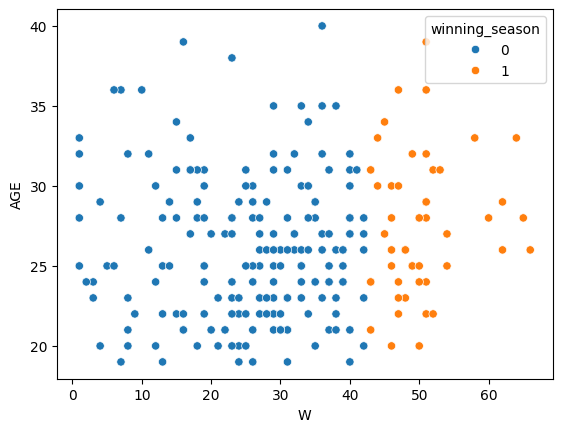

In [10]:
def winning_season(wins):

  if wins > 42:
      return 1
  return 0

df["winning_season"] = df["W"].apply(winning_season)

import seaborn as sns
sns.scatterplot(x='W', y='AGE', hue='winning_season', data =df)

**Modeling**

In [11]:
df2 = df[["AGE", "POINTS", "SALARY_MILLIONS","PAGEVIEWS",
          "TWITTER_FAVORITE_COUNT","winning_season","TOV"]]

In [12]:
df = df2.dropna()

In [13]:
target = df["winning_season"]
features = df[["AGE", "POINTS", "SALARY_MILLIONS","PAGEVIEWS",
                         "TWITTER_FAVORITE_COUNT","TOV"]]
classes = ["winning", "losing"]

In [14]:
df2.shape

(239, 7)

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25,
                                                    random_state=0)

In [16]:
x_train.shape

(177, 6)

**Use Logistic Regression**

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
model = LogisticRegression(solver='lbfgs',max_iter=1000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [19]:
LogisticRegression(C=1.0,class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None,max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs',tol=0.0001,verbose=0,
                   warm_start=False)

LogisticRegression(max_iter=1000)

**Model Explainability**

**Using SHAP**

In [20]:
!pip install -q shap

In [21]:
import xgboost
import shap

In [22]:
model_xgboost = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(x_train,label=y_train))

#Load JS visualization code to notebook
shap.initjs()

#explain the model's predictions using SHAP values
#(same syntax works or LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model_xgboost)
shap_values = explainer.shap_values(features)

#visualize the first prediction's explanantion (use matplotlib=True to avoid javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:],features.iloc[0,:])

**Mean absolute values**

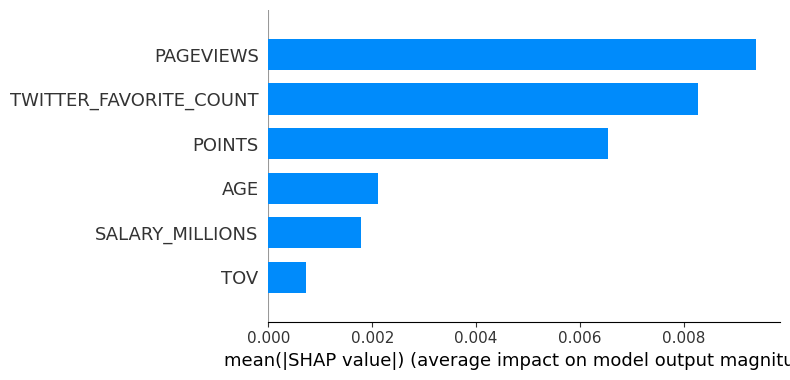

In [23]:
shap.summary_plot(shap_values, features, plot_type='bar')

In [24]:
#!pip install --upgrade eli5

In [25]:
#pip install scikit-learn==1.2.2

In [26]:
import eli5

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [27]:
from eli5.sklearn import PermutationImportance

In [28]:
perm = PermutationImportance(model, random_state=1).fit(x_train, y_train)
eli5.show_weights(perm, feature_names= features.columns.tolist())

Weight,Feature
0.0090 ± 0.0055,TOV
0.0079 ± 0.0136,POINTS
0.0056 ± 0.0000,PAGEVIEWS
0.0056 ± 0.0071,SALARY_MILLIONS
0.0034 ± 0.0055,TWITTER_FAVORITE_COUNT
-0.0079 ± 0.0055,AGE
